# Import packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Coordinate Q learning

## build Q learning

In [3]:
# 實際進行訓練的 evaluation network
class Eval_Q_Model(tf.keras.Model):
  # Evaluate Q Model 的模型架構
  def __init__(self, num_actions):
    super().__init__('mlp_q_network')
    self.layer1 = layers.Dense(10, activation='relu')
    self.logits = layers.Dense(num_actions, activation=None)

  def call(self, inputs):
    x = tf.convert_to_tensor(inputs)
    layer1 = self.layer1(x)
    logits = self.logits(layer1)
    return logits

In [4]:
# 久久更新一次的 evaluation network
class Target_Q_Model(tf.keras.Model):
  # Target Q Model 的模型架構(不更新layer權重)
  def __init__(self, num_actions):
    super().__init__('mlp_q_network_1')
    self.layer1 = layers.Dense(10, trainable=False, activation='relu')
    self.logits = layers.Dense(num_actions, trainable=False, activation=None)

  def call(self, inputs):
    x = tf.convert_to_tensor(inputs)
    layer1 = self.layer1(x)
    logits = self.logits(layer1)
    return logits

In [5]:
class DeepQNetwork:
  def __init__(self, n_actions, n_features, eval_model, target_model):
    # 利用dic儲存參數
    self.params = {
        'n_actions': n_actions,     # actions數量
        'n_features': n_features,    # features數量 
        'learning_rate': 0.01,
        'reward_decay': 0.9,
        'e_greedy': 0.9,         # 選擇隨機action的機率
        'replace_target_iter': 300,   # 從 Eval_Q_Model 更新 Target_Q_Model 需要的迭代次數
        'memory_size': 500,
        'batch_size': 32,
        'e_greedy_increment': None
        }

    # total learning step
    self.learn_step_counter = 0
    # epsilon 表機率，訓練過程中有 epsilon 的機率 agent 會選擇隨機
    self.epsilon = 0 if self.params['e_greedy_increment'] is not None else self.params['e_greedy']
    # initialize zero memory ，每個 memory 中的 experience 大小為 (state + next state + reward + action)
    self.memory = np.zeros((self.params['memory_size'], self.params['n_features'] * 2 + 2))

    self.eval_model = eval_model
    self.target_model = target_model

    self.eval_model.compile(
        optimizer=RMSprop(learning_rate=self.params['learning_rate']),
        loss='mse'
        )
    self.cost_his = []

  ## 儲存經驗
  def store_transition(self, s, a, r, s_):
    if not hasattr(self, 'memory_counter'):
      self.memory_counter = 0

    # 打包agent經驗
    transition = np.hstack((s, [a, r], s_))

    # 用新memory取代舊memory
    index = self.memory_counter % self.params['memory_size']
    self.memory[index, :] = transition
    self.memory_counter += 1

  ## 決定是否具有隨機以及隨機的方式
  def choose_action(self, observation):
    # to have batch dimension when feed into tf placeholder
    observation = observation[np.newaxis, :]

    if np.random.uniform() < self.epsilon:
    # 透過觀察得到每個 action 的 q 值
      actions_value = self.eval_model.predict(observation)
      print(actions_value)
      action = np.argmax(actions_value)
    else: # 隨機移動
      action = np.random.randint(0, self.params['n_actions'])
    return action

  ## 從 memory 中取樣學習
  def learn(self):
    # 從 memory 取樣 batch memory
    if self.memory_counter > self.params['memory_size']:
      sample_index = np.random.choice(self.params['memory_size'], size=self.params['batch_size'])
    else:
      sample_index = np.random.choice(self.memory_counter, size=self.params['batch_size'])

    batch_memory = self.memory[sample_index, :]

    # 計算現在 eval net 和 target net 得出 Q value 的落差
    q_next = self.target_model.predict(batch_memory[:, -self.params['n_features']:])
    q_eval = self.eval_model.predict(batch_memory[:, :self.params['n_features']])

    # 根據 q_eval 改變 q_target
    q_target = q_eval.copy()

    batch_index = np.arange(self.params['batch_size'], dtype=np.int32)
    eval_act_index = batch_memory[:, self.params['n_features']].astype(int)
    reward = batch_memory[:, self.params['n_features'] + 1]

    q_target[batch_index, eval_act_index] = reward + self.params['reward_decay'] * np.max(q_next, axis=1)

    # check to replace target parameters
    if self.learn_step_counter % self.params['replace_target_iter'] == 0:
      for eval_layer, target_layer in zip(self.eval_model.layers, self.target_model.layers):
        target_layer.set_weights(eval_layer.get_weights())
      print('\ntarget_params_replaced\n')

    # train eval network
    self.cost = self.eval_model.train_on_batch(batch_memory[:, :self.params['n_features']], q_target)
    self.cost_his.append(self.cost)

    # 增加 epsilon ，使 agent 傾向不隨機
    self.epsilon = self.epsilon + self.params['e_greedy_increment'] if self.epsilon < self.params['e_greedy'] else self.params['e_greedy']
    self.learn_step_counter += 1

  def plot_cost(self):
    plt.plot(np.arange(len(self.cost_his)), self.cost_his)
    plt.ylabel('Cost')
    plt.xlabel('training steps')
    plt.show()

In [6]:
def run_cleaner(ag, RL):
  step = 0

  action = 1
  n_states = ag.get_env()
  error_flag, reward, done_flag = ag.step(action)
  n_states_new = ag.get_env()
  RL.store_transition(n_states, action, reward, n_states_new)

  for episode in range(300):
    # RL 選擇 action
    action = RL.choose_action(n_states_new)
    # 執行 action 並得到下一階段 info
    n_states = n_states_new
    error_flag, reward, done_flag = ag.step(action)
    n_states_new = ag.get_env()
    RL.store_transition(n_states, action, reward, n_states_new)

    if (step > 200) and (step % 5 == 0):
      RL.learn()

    # break while loop when end of this episode
    if done_flag:
      print('Episode finished after {} timesteps, total rewards {}'.format(step+1, rewards))
      break
    step += 1
  # end of game
  print('over')

## build enviroment

In [7]:
class enviroment:
	def __init__(self):
		self.env = []
		self.wall = []

	def initial(self, setini):
		#	setini[0]：環境長	setini[1]：環境寬
		self.env = np.full((setini[0]+2, setini[1]+2), False, dtype=bool)
		self.wall = np.full((setini[0]+2, setini[1]+2), False, dtype=bool)

		#	包邊 w
		for j in range(setini[1]+2):
			self.wall[0][j] = 1
			self.wall[setini[0]+1][j] = 1
		for i in range(setini[0]+2):
			self.wall[i][0] = 1
			self.wall[i][setini[1]+1] = 1

	def set_wall(self, wall):
		for i in wall:
			if( i[1]>=np.size(self.env,1) or i[0]>=np.size(self.env,0) ): print("error",i)
			else:	self.wall[ i[1]+1 ][ i[0]+1 ] = 1

	def play(self):
		for i in range(np.size(self.env,0)):
			for j in range(np.size(self.env,1)):
				if(self.wall[i][j]):	print("w", end=" ")
				elif(self.env[i][j]):	print("■", end=" ")
				else:	print("□", end=" ")
			print("")

def agent_play_env(x, y, env):
	x_bound = np.size(env.env,1)
	y_bound = np.size(env.env,0)
	for i in range(-1,2,1):
		for j in range(-1,2,1):
			if( (j+x+1)>=x_bound or (i+y+1)>=y_bound ): print("error",i+x,j+j, end=" ")
			elif(i==0 and j==0):	print("a", end=" ")
			elif(env.wall[y+i+1][x+j+1]):	print("w", end=" ")
			elif(env.env[y+i+1][x+j+1]):	print("■", end=" ")
			else:	print("□", end=" ")
		print("")

In [8]:
def agent_play_env_full(x, y, env):
  print(x,y)
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  for i in range(np.size(env.env,0)):
    for j in range(np.size(env.env,1)):
      if(i==y+1 and j==x+1):	print("a", end=" ")
      elif(env.wall[i][j]):	print("w", end=" ")
      elif(env.env[i][j]):	print("■", end=" ")
      else:	print("□", end=" ")
    print("")

def agent_play_env(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  for i in range(-1,2,1):
    for j in range(-1,2,1):
      if( (j+x+1)>=x_bound or (i+y+1)>=y_bound ): print("error",i+x,j+j, end=" ")
      elif(i==0 and j==0):  print("a", end=" ")
      elif(env.wall[y+i+1][x+j+1]):	print("w", end=" ")
      elif(env.env[y+i+1][x+j+1]):  print("■", end=" ")
      else:	print("□", end=" ")
    print("")

def agent_get_env(x, y, env):
  state =  np.zeros(9)
  for i in range(-1,2,1):
    for j in range(-1,2,1):
      if(i==0 and j==0):  pass
      elif(env.wall[y+i+1][x+j+1]): state[(j+1)+3*(i+1)] = 1
      elif(env.env[y+i+1][x+j+1]):  state[(j+1)+3*(i+1)] = 2
      else:	state[(j+1)+3*(i+1)] = 0
  return state

def agent_wall_test(x, y, env):
  x_bound = np.size(env.env,1)
  y_bound = np.size(env.env,0)
  if( (x+1)>=x_bound or (y+1)>=y_bound ): return 2
  elif(env.wall[y+1][x+1]==1):	return 1
  else:	return 0

class agent():
  def __init__(self):
    self.locx = -1
    self.locy = -1
    self.flag = 0
    self.bound_error = 0
    self.n_actions = 2
    self.n_features = np.zeros(9)
    self.env = 0

  def initial(self, env):
    self.env = env
    self.locx = 0
    self.locy = 0

  def set_loc(self, y, x):
    flag = agent_wall_test(x, y, self.env)
    if(flag==1):  print("wall_error")
    elif(flag==2):  print("bound_error")
    else:
      self.locx = x
      self.locy = y

  def loc_test(self, y, x):
    flag = agent_wall_test(x, y, self.env)
    if(flag==1):
      print("wall_error")
    elif(flag==2):	
      print("bound_error")
    return flag

  def go_right(self):
    self.locx += 1

  def go_left(self):
    self.locx -= 1

  def go_up(self):
    self.locy -= 1

  def go_down(self):
    self.locy += 1

  def go(self,do):
    if(do==0):	
      flag = self.loc_test(self.locy-1, self.locx)
      if(flag==0):  self.go_up()
    elif(do==1):
      flag = self.loc_test(self.locy+1, self.locx)
      if(flag==0):  self.go_down()
    elif(do==2):
      flag = self.loc_test(self.locy, self.locx-1)
      if(flag==0):  self.go_left()
    elif(do==3):
      flag = self.loc_test(self.locy, self.locx+1)
      if(flag==0):  self.go_right()
    self.flag = flag

  def get_env(self):
    return agent_get_env(self.locx, self.locy, self.env)

  def step(self,action):
    self.go(action)
    done = False

    # reward設計
    if(self.flag==1): reward = -1
    elif(self.flag==2):
      self.wall_error += 1
      reward = -1*(self.wall_error if self.wall_error<4 else 4)
    else: reward = 0.1 

    # 取得下一階段state
    state = agent_get_env(self.locx, self.locy, self.env)

    # 是否end game
    if(self.bound_error>10):  done = True

    return self.flag, reward, done

  def play(self):
    print("Location：", self.locx, self.locy)
    agent_play_env(self.locx, self.locy, self.env)

  def full_play(self):
    print("Location：", self.locx, self.locy)
    agent_play_env_full(self.locx, self.locy, self.env)	

## main

env = 10*10
memory_size = 500

In [ ]:
# 環境初始化
env = enviroment()
env.initial([10,10])
wall = np.array( [ [5, 0], [5, 1] ] )
env.set_wall( wall )

# agent初始化
ag = agent()
ag.initial(env)
ag.set_loc(0, 0)

eval_model = Eval_Q_Model(num_actions=4)
target_model = Target_Q_Model(num_actions=4)
RL = DeepQNetwork(4, 9, eval_model, target_model)
for i in range(10):
  run_cleaner(ag, RL)

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 18ms/step
[[ 0.07311314  0.11024575 -0.06402184 -0.01339279]]
1/1 [==============================] - 0s 25ms/step
[[ 0.21991059 -0.16492583 -0.01160382 -0.05996326]]
1/1 [==============================] - 0s 18ms/step
[[ 0.07311314  0.11024575 -0.06402184 -0.01339279]]
1/1 [==============================] - 0s 21ms/step
[[ 0.21991059 -0.16492583 -0.01160382 -0.05996326]]
wall_error
1/1 [==============================] - 0s 18ms/step
[[ 0.08428241  0.10002214 -0.05957703  0.00674905]]
1/1 [==============================] - 0s 18ms/step
[[ 0.22600822 -0.1645303  -0.00854165 -0.06152224]]
1/1 [==============================] - 0s 18ms/step
[[ 0.08428241  0.10002214 -0.05957703  0.00674905]]
1/1 [==============================] - 0s 17ms/step
[[ 0.22600822 -0.1645303  -0.00854165 -0.06152224]]
1/1 [==============================] - 0s 17ms/step
[[ 0.08428241  0.10002214 -0.05957703  0.00674905]]
1/1 [===========================

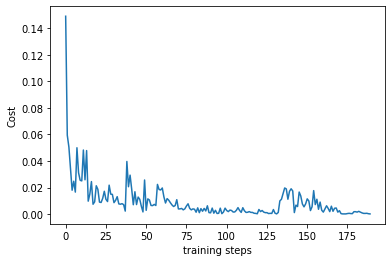

In [ ]:
RL.plot_cost()

env = 10*10
memory_size = 200

In [10]:
# 環境初始化
env2 = enviroment()
env2.initial([10,10])
wall = np.array( [ [5, 0], [5, 1] ] )
env2.set_wall( wall )

# agent初始化
ag2 = agent()
ag2.initial(env2)
ag2.set_loc(0, 0)

eval_model_2 = Eval_Q_Model(num_actions=4)
target_model_2 = Target_Q_Model(num_actions=4)
RL200 = DeepQNetwork(4, 9, eval_model_2, target_model_2)
RL200.params['memory_size'] = 200
for i in range(10):
  run_cleaner(ag2, RL200)

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 18ms/step
[[0.05834851 0.36732298 0.59502727 0.40752745]]
1/1 [==============================] - 0s 22ms/step
[[-0.5714239  -0.25385362  0.2537316   0.58104867]]
1/1 [==============================] - 0s 22ms/step
[[0.05834851 0.36732298 0.59502727 0.40752745]]
1/1 [==============================] - 0s 18ms/step
[[-0.5714239  -0.25385362  0.2537316   0.58104867]]
1/1 [==============================] - 0s 17ms/step
[[0.05834851 0.36732298 0.59502727 0.40752745]]
1/1 [==============================] - 0s 17ms/step
[[-0.5714239  -0.25385362  0.2537316   0.58104867]]
1/1 [==============================] - 0s 20ms/step
[[0.05834851 0.36732298 0.59502727 0.40752745]]
1/1 [==============================] - 0s 20ms/step
[[-0.5714239  -0.25385362  0.2537316   0.58104867]]
1/1 [==============================] - 0s 18ms/step
[[0.05834851 0.36732298 0.59502727 0.40752745]]
1/1 [==============================] - 0s 17ms/step
[[-0.571423

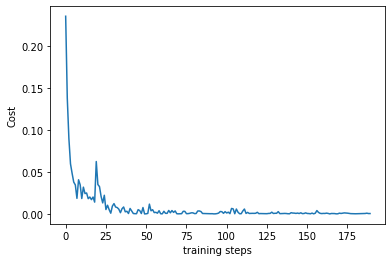

In [11]:
RL200.plot_cost()

env = 10*10
memory_size = 100

In [12]:
# 環境初始化
env3 = enviroment()
env3.initial([10,10])
wall = np.array( [ [5, 0], [5, 1] ] )
env3.set_wall( wall )

# agent初始化
ag3 = agent()
ag3.initial(env3)
ag3.set_loc(0, 0)

eval_model_3 = Eval_Q_Model(num_actions=4)
target_model_3 = Target_Q_Model(num_actions=4)
RL100 = DeepQNetwork(4, 9, eval_model_3, target_model_3)
RL100.params['memory_size'] = 200
for i in range(10):
  run_cleaner(ag3, RL100)

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 18ms/step
[[-0.5816126   0.3180995   0.60565096  0.10670874]]
wall_error
1/1 [==============================] - 0s 25ms/step
[[-0.5816126   0.3180995   0.60565096  0.10670874]]
wall_error
1/1 [==============================] - 0s 25ms/step
[[-0.5816126   0.3180995   0.60565096  0.10670874]]
wall_error
1/1 [==============================] - 0s 21ms/step
[[-0.5816126   0.3180995   0.60565096  0.10670874]]
wall_error
1/1 [==============================] - 0s 27ms/step
[[-0.5816126   0.3180995   0.60565096  0.10670874]]
wall_error
1/1 [==============================] - 0s 18ms/step
[[-0.5855707   0.3514824   0.55064535  0.15413454]]
wall_error
1/1 [==============================] - 0s 20ms/step
[[-0.5855707   0.3514824   0.55064535  0.15413454]]
wall_error
1/1 [==============================] - 0s 22ms/step
[[-0.5855707   0.3514824   0.55064535  0.15413454]]
wall_error
1/1 [==============================] - 0s 19ms/step
[[-0.58

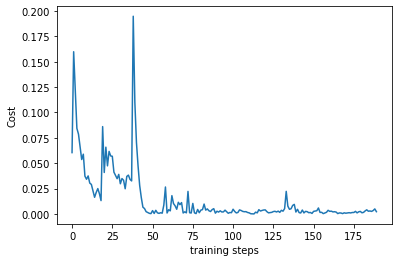

In [13]:
RL100.plot_cost()

env = 5*5
memory_size = 200

In [21]:
# 環境初始化
env4 = enviroment()
env4.initial([5,5])
wall = np.array( [ [2, 0] ] )
env4.set_wall( wall )

# agent初始化
ag4 = agent()
ag4.initial(env4)
ag4.set_loc(0, 0)

env4.play()

eval_model_4 = Eval_Q_Model(num_actions=4)
target_model_4 = Target_Q_Model(num_actions=4)
RL55 = DeepQNetwork(4, 9, eval_model_4, target_model_4)
RL55.params['memory_size'] = 200
for i in range(10):
  run_cleaner(ag4, RL55)

串流輸出內容已截斷至最後 5000 行。
[[0.0997826  0.24161176 0.6431449  0.6288671 ]]
wall_error
1/1 [==============================] - 0s 25ms/step
[[0.0997826  0.24161176 0.6431449  0.6288671 ]]
wall_error
1/1 [==============================] - 0s 20ms/step
[[0.10255    0.26227108 0.7155386  0.65836763]]
wall_error
1/1 [==============================] - 0s 19ms/step
[[0.64631695 0.14325333 0.2153765  0.60483265]]
1/1 [==============================] - 0s 23ms/step
[[0.10255    0.26227108 0.7155386  0.65836763]]
wall_error
1/1 [==============================] - 0s 19ms/step
[[0.10255    0.26227108 0.7155386  0.65836763]]
wall_error
1/1 [==============================] - 0s 19ms/step
[[0.10480269 0.27639028 0.7456747  0.6585124 ]]
wall_error
1/1 [==============================] - 0s 19ms/step
[[0.10480269 0.27639028 0.7456747  0.6585124 ]]
wall_error
1/1 [==============================] - 0s 28ms/step
[[0.10480269 0.27639028 0.7456747  0.6585124 ]]
wall_error
1/1 [==============================] - 0s 3

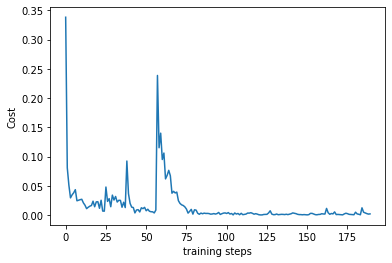

In [22]:
RL55.plot_cost()

env = 20*20
memory_size = 200

In [23]:
# 環境初始化
env5 = enviroment()
env5.initial([20,20])
wall = np.array( [ [10, 0], [10, 1], [10, 2], [10, 3], [11, 0], [11, 1], [11, 2], [11, 3] ] )
env5.set_wall( wall )

# agent初始化
ag5 = agent()
ag5.initial(env5)
ag5.set_loc(0, 0)

eval_model_5 = Eval_Q_Model(num_actions=4)
target_model_5 = Target_Q_Model(num_actions=4)
RL2020 = DeepQNetwork(4, 9, eval_model_5, target_model_5)
RL2020.params['memory_size'] = 200
for i in range(10):
  run_cleaner(ag5, RL2020)

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 38ms/step
[[ 0.5404129  -0.34884858 -0.79311246  0.01145789]]
1/1 [==============================] - 0s 19ms/step
[[ 0.316611    0.3867485  -0.42607772 -0.22069761]]
1/1 [==============================] - 0s 23ms/step
[[ 0.5404129  -0.34884858 -0.79311246  0.01145789]]
1/1 [==============================] - 0s 25ms/step
[[ 0.316611    0.3867485  -0.42607772 -0.22069761]]
1/1 [==============================] - 0s 22ms/step
[[ 0.5404129  -0.34884858 -0.79311246  0.01145789]]
1/1 [==============================] - 0s 21ms/step
[[ 0.316611    0.3867485  -0.42607772 -0.22069761]]
1/1 [==============================] - 0s 25ms/step
[[ 0.5404129  -0.34884858 -0.79311246  0.01145789]]
1/1 [==============================] - 0s 20ms/step
[[ 0.316611    0.3867485  -0.42607772 -0.22069761]]
1/1 [==============================] - 0s 23ms/step
[[ 0.5404129  -0.34884858 -0.79311246  0.01145789]]
1/1 [==============================] - 0s 2

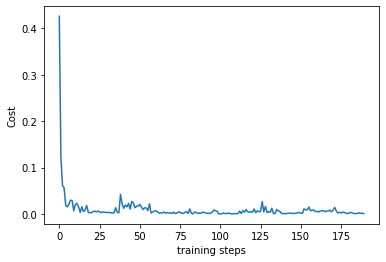

In [24]:
RL2020.plot_cost()

10*10複雜空間

In [30]:
# 環境初始化
env6 = enviroment()
env6.initial([10,10])
wall = np.array( [ [5, 0], [5, 1], [7, 5], [7, 6], [8, 6], [9, 6] ] )
wall2 = np.array( [ [2, 5], [2, 6], [2, 7], [2, 8], [2, 9] ] )
wall3 = np.array( [ [1, 1], [1, 2], [2, 1], [2, 2] ] )
env6.set_wall( wall )
env6.set_wall( wall2 )
env6.set_wall( wall3 )

# agent初始化
ag6 = agent()
ag6.initial(env6)
ag6.set_loc(0, 0)

eval_model_6 = Eval_Q_Model(num_actions=4)
target_model_6 = Target_Q_Model(num_actions=4)
RLGO = DeepQNetwork(4, 9, eval_model_6, target_model_6)
RLGO.params['memory_size'] = 200
for i in range(10):
  run_cleaner(ag6, RLGO)

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 19ms/step
[[ 0.126277   -0.6858189  -0.4375019   0.01010227]]
1/1 [==============================] - 0s 20ms/step
[[-0.21156603  0.07897302 -0.22613229  0.01658154]]
1/1 [==============================] - 0s 21ms/step
[[ 0.126277   -0.6858189  -0.4375019   0.01010227]]
1/1 [==============================] - 0s 22ms/step
[[-0.25094515  0.04974131 -0.33456692  0.02070218]]
1/1 [==============================] - 0s 22ms/step
[[ 0.10166131 -0.70967114 -0.5718255   0.05406669]]
1/1 [==============================] - 0s 21ms/step
[[-0.25094515  0.04974131 -0.33456692  0.02070218]]
1/1 [==============================] - 0s 20ms/step
[[ 0.10166131 -0.70967114 -0.5718255   0.05406669]]
1/1 [==============================] - 0s 27ms/step
[[-0.25094515  0.04974131 -0.33456692  0.02070218]]
1/1 [==============================] - 0s 17ms/step
[[ 0.07018625 -0.72008735 -0.6560474   0.07256645]]
1/1 [==============================] - 0s 1

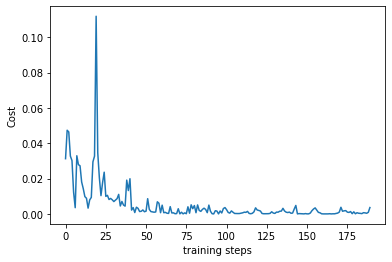

In [31]:
RLGO.plot_cost()

## predict test

In [ ]:
# agent初始化
ag = agent()
ag.initial(env)
ag.set_loc(0, 0)

In [ ]:
ag.full_play()
for i in range(20):
  ag.go(RL.choose_action(ag.get_env()))
  ag.full_play()

Location： 0 0
0 0
w w w w w w w w w w w w 
w a □ □ □ □ w □ □ □ □ w 
w □ □ □ □ □ w □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w w w w w w w w w w w w 
1/1 [==============================] - 0s 19ms/step
[[-0.531706    0.05292882 -1.2044388   0.5081245 ]]
Location： 1 0
1 0
w w w w w w w w w w w w 
w □ a □ □ □ w □ □ □ □ w 
w □ □ □ □ □ w □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w w w w w w w w w w w w 
1/1 [==============================] - 0s 22ms/step
[[-0.3650988   0.21989816 -0.6366566   0.6783427 ]]
Location： 2 0
2 0
w w w w w w w w w w w w 
w □ □ a □ □ w □ □ □ □ w 
w □ □ □ □ □ w □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □ □ □ □ □ w 
w □ □ □ □ □ □

# Reference
  1. https://www.youtube.com/watch?v=a4Yfz2FxXiY
  2. https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46
  3. https://zhuanlan.zhihu.com/p/70009692
  4. https://mofanpy.com/

# Build GAN enviroment

In [ ]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

In [ ]:
# 移動至PyTorch-GAN
os.chdir(os.path.dirname(os.path.abspath("__file__"))+'/PyTorch-GAN')

In [ ]:
# 安裝相關需求檔案
!pip3 install -r requirements.txt

## Build Generator

In [ ]:
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    #encoder
    self.model = nn.Module

  def call(self, inputs, training=None):
    img = self.model(z)
    img = img.view(img.size(0), *img_shape)
    return img

## Build Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(int(np.prod(img_shape)), 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid(),
    )

  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    validity = self.model(img_flat)
    return validity

## Loss function

In [ ]:
adversarial_loss = torch.nn.BCELoss()